In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt  
import imblearn
import numpy as np

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder,KFold, cross_val_score,train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,mean_squared_error,confusion_matrix,ConfusionMatrixDisplay,mean_absolute_error

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from imblearn.under_sampling import NearMiss 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product


## Time seried model for revenue prediction

In [46]:
df_ts = df_clean_model
df_ts.columns

Index(['channelGrouping', 'fullVisitorId', 'visitNumber', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'totals.hits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.campaign', 'trafficSource.medium', 'madeTransaction',
       'location', 'time', 'hour', 'weekday', 'month', 'domain_type',
       'source'],
      dtype='object')

<Axes: xlabel='date'>

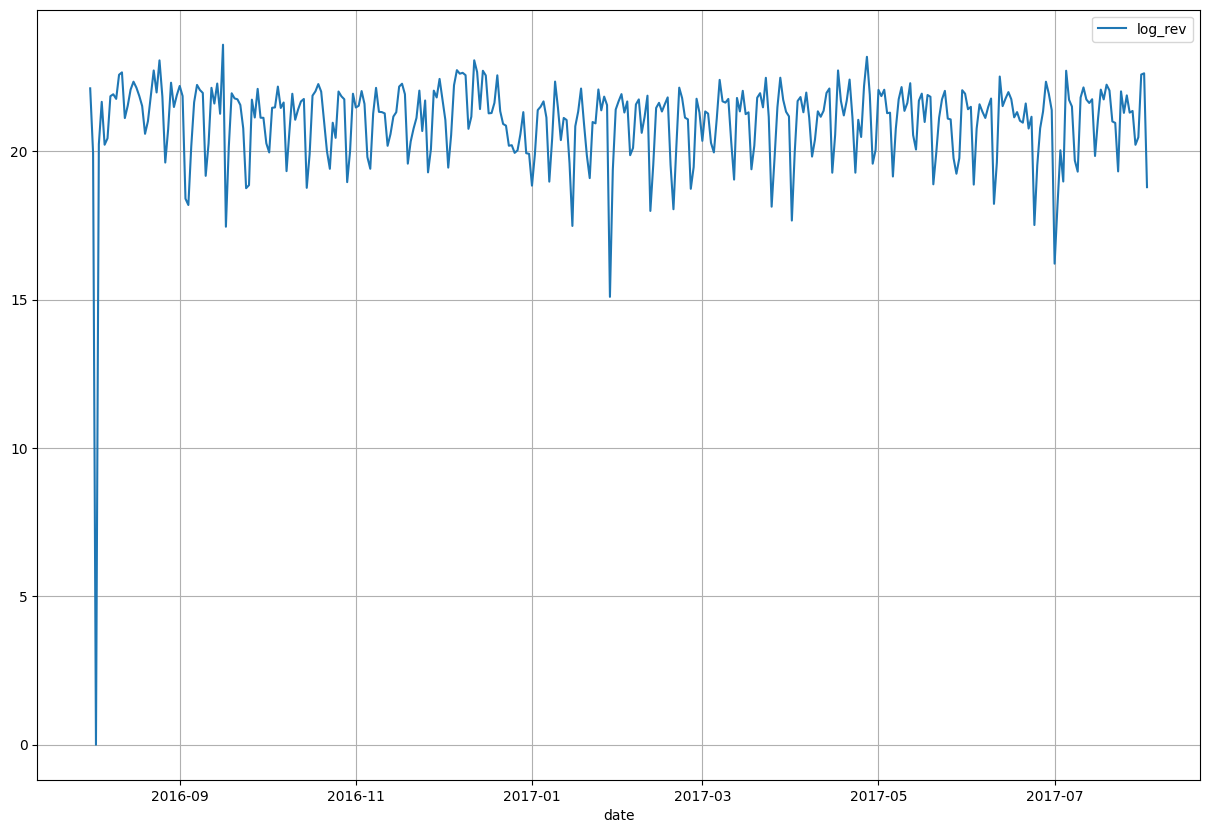

In [48]:
# Change date column data type as date 
df_ts['date'] = pd.to_datetime(df_ts['time'], format='%Y-%m-%d %H:%M:%S.%f').dt.date

# Get daily total revenue by grouping by date
df_rev = df_ts.groupby(['date'])['totals.transactionRevenue'].sum().reset_index()

# Take log of revenue and add a smoothing factor of 1
df_rev['log_rev'] =  np.log(df_rev['totals.transactionRevenue']+1)

# Visualize daily revenue
df_rev.plot.line(x='date', y='log_rev',figsize=(15, 10),grid=True)

In [49]:
df_rev.describe()

,totals.transactionRevenue,log_rev
count,3.670000e+02,367.000000
mean,2.248614e+09,20.997820
std,2.010250e+09,1.614874
min,0.000000e+00,0.000000
25%,6.818050e+08,20.340201
50%,1.846940e+09,21.336796
75%,3.109110e+09,21.857601
max,1.759041e+10,23.590620


From the above plot and database summary we can see that the third day revenue is 0, which is an outlier. As it is one of the first several days of data, we decided to drop the first three day data.

<Axes: xlabel='date'>

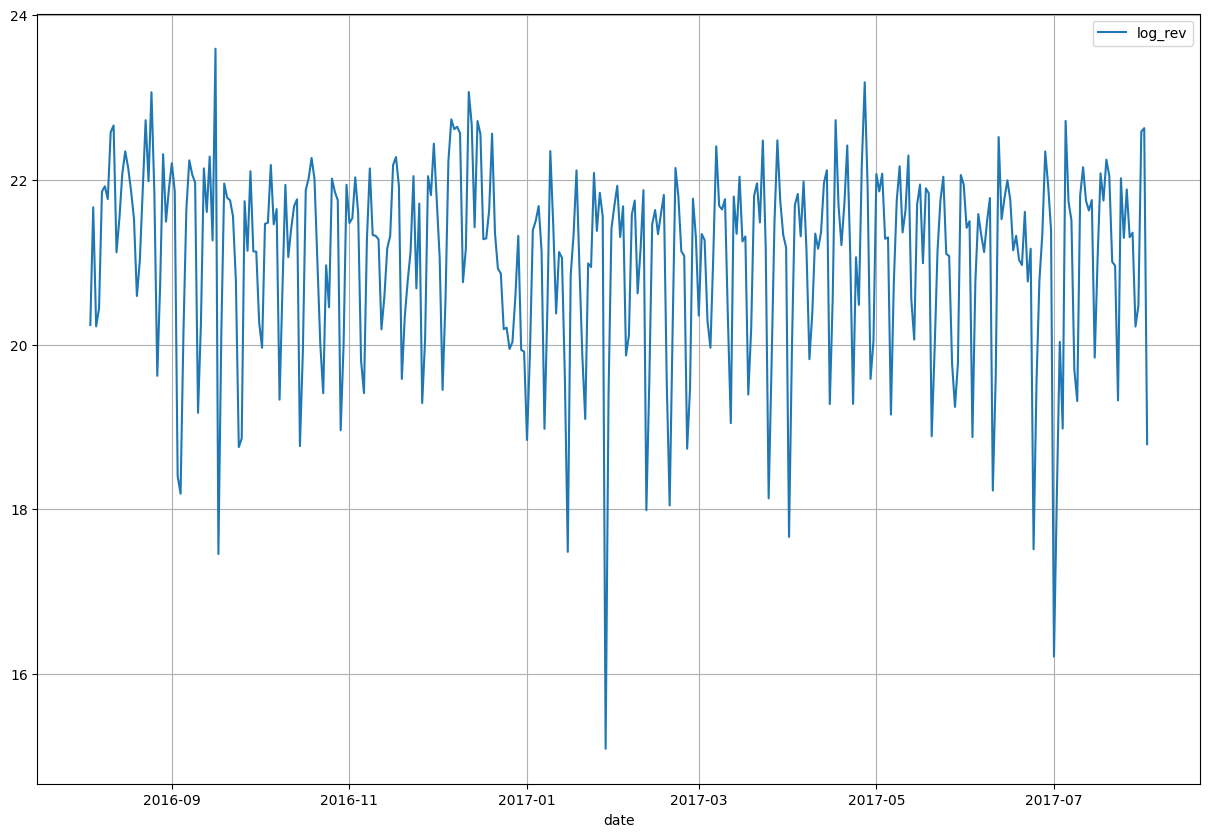

In [51]:
df_rev_ol = df_rev.iloc[3:]
df_rev_ol.plot.line(x='date', y='log_rev',figsize=(15, 10),grid=True)

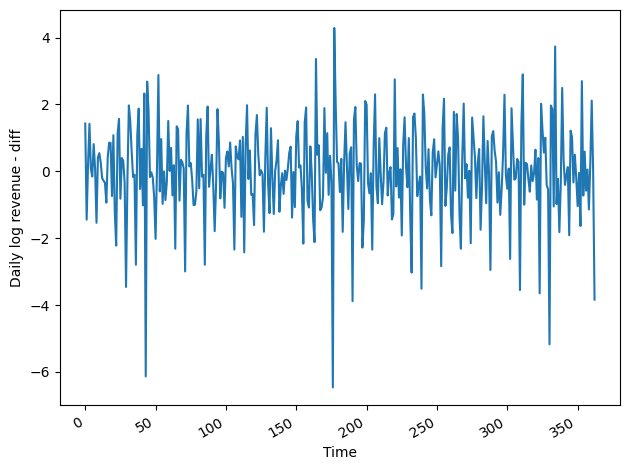

In [53]:
# Draw daily revenue difference with lage of 1
log_rev_dff = np.diff(df_rev_ol.log_rev, n=1)
fig, ax = plt.subplots()

ax.plot(log_rev_dff)
ax.set_xlabel('Time')
ax.set_ylabel('Daily log revenue - diff')


fig.autofmt_xdate()
plt.tight_layout()

### Run ADF test to see if data is stationary

In [54]:
ADF_result = adfuller(log_rev_dff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -7.614291272276312
p-value: 2.2128274871571978e-11


### Split data into training data and testing data. Set last 30 days as testing data

In [55]:
df_diff = pd.DataFrame({'log_rev_dff': log_rev_dff})

train = df_diff[:-30]
test = df_diff[-30:]

print(len(train))
print(len(test))

333
30


### Visualization of autocorrelation

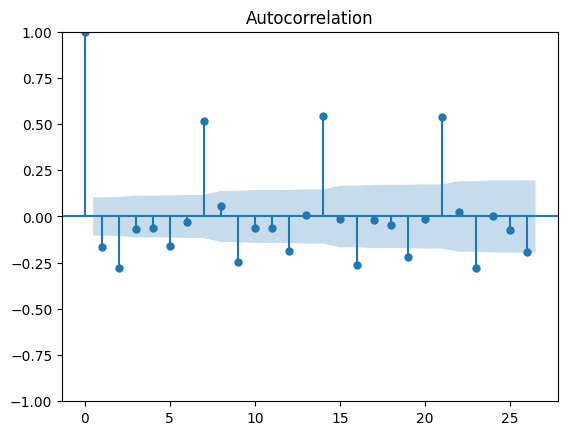

In [56]:
df_diff["log_rev_dff"].iloc[0] = 0
plot_acf(df_diff["log_rev_dff"])
plt.show()

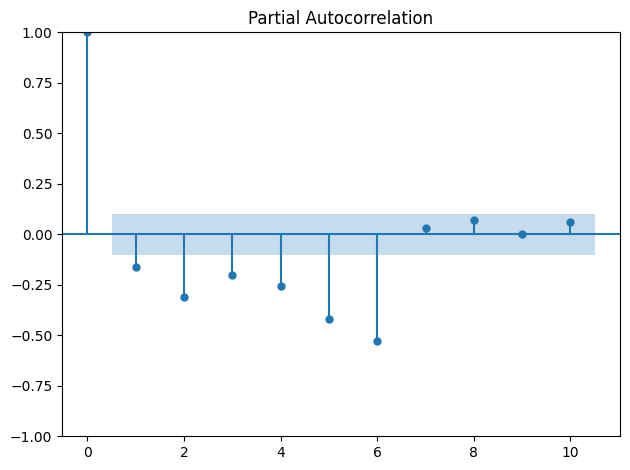

In [57]:
plot_pacf(df_diff, lags=10)

plt.tight_layout()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)

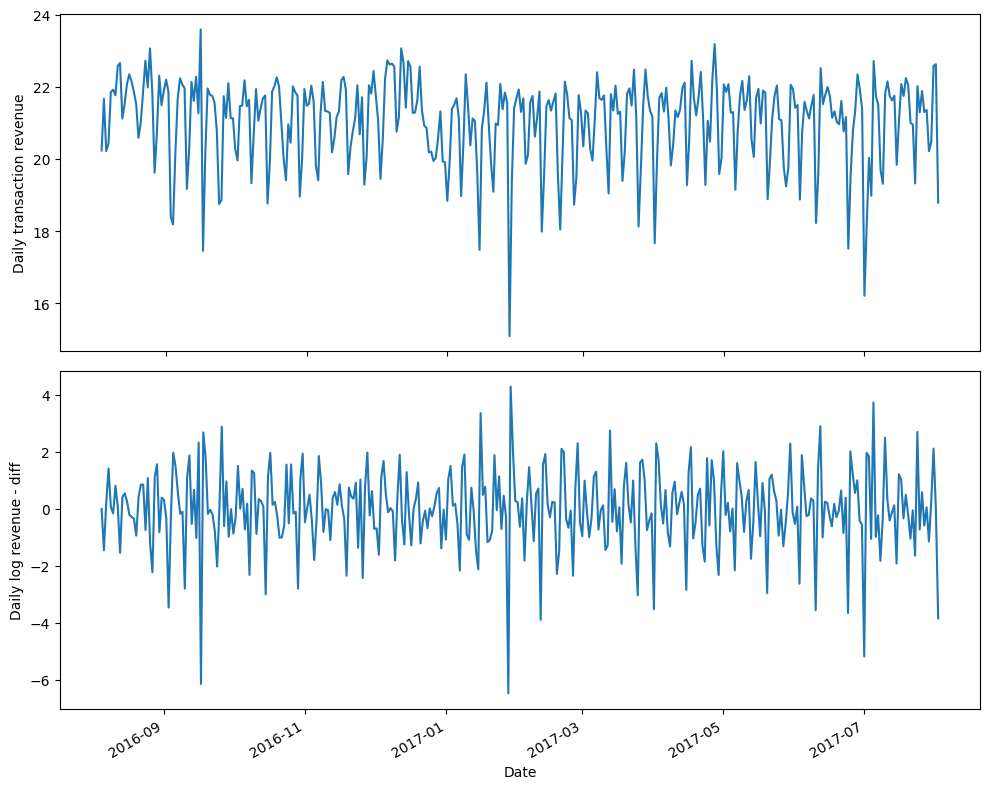

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

ax1.plot(df_rev_ol['date'],df_rev_ol['log_rev'])
ax1.set_xlabel('Day')
ax1.set_ylabel('Daily transaction revenue')

ax2.plot(df_rev_ol['date'].iloc[1:],df_diff['log_rev_dff'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Daily log revenue - diff')



fig.autofmt_xdate()
plt.tight_layout()

plt.show()

### Optimize ARMA(p,q)

In [59]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [179]:
# Experiment different combinations of p and q
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [61]:
result_df = optimize_ARMA(train['log_rev_dff'], order_list)
result_df

/var/folders/6p/hj30p4zj3n5dch8x1cy1bhyw0000gn/T/ipykernel_4400/3649428702.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/16 [00:00<?, ?it/s]

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Us

,"(p,q)",AIC
0,"(2, 2)",990.654844
1,"(3, 3)",993.249550
2,"(2, 3)",998.949703
3,"(3, 1)",1005.548963
4,"(2, 1)",1009.090066
5,"(3, 2)",1012.599843
6,"(0, 2)",1018.898884
7,"(0, 3)",1019.967580
8,"(1, 2)",1020.446758
9,"(1, 3)",1021.950607


From the results above we can see that (3,3) can be a good fit to feed into SARIMAX model

### Prediction model

In [156]:
%%time
model = SARIMAX(train['log_rev_dff'], order=(3,1,3), simple_differencing=False)


CPU times: user 852 µs, sys: 332 µs, total: 1.18 ms
Wall time: 890 µs


In [157]:
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            log_rev_dff   No. Observations:                  333
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -533.148
Date:                Mon, 11 Dec 2023   AIC                           1080.296
Time:                        08:12:32   BIC                           1106.932
Sample:                             0   HQIC                          1090.919
                                - 333                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6605      0.056    -11.870      0.000      -0.770      -0.551
ar.L2         -1.0837      0.025    -42.602      0.000      -1.134      -1.034
ar.L3         -0.2084      0.056     -3.727      0.0

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



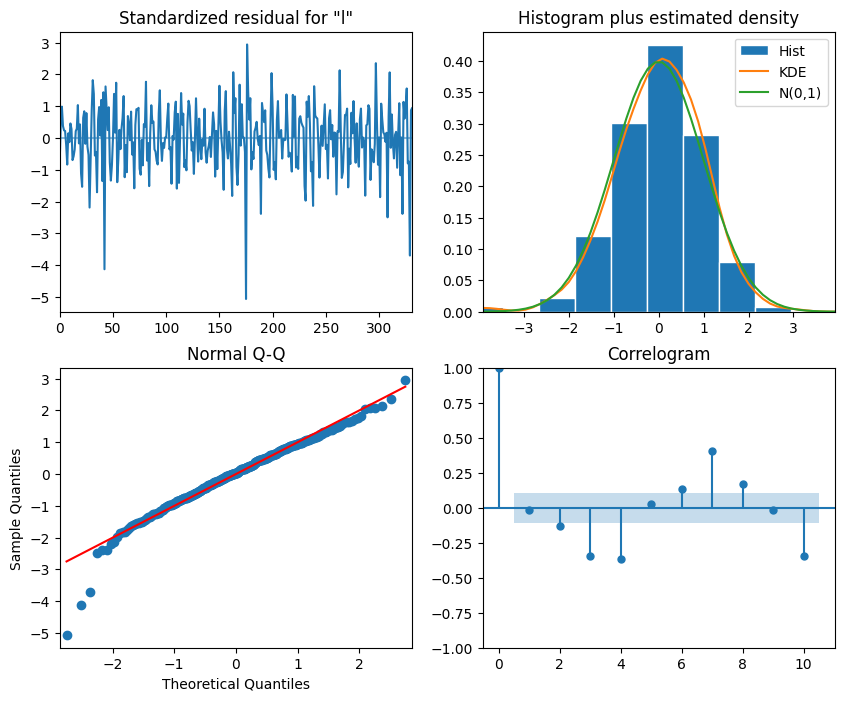

In [158]:
model_fit.plot_diagnostics(figsize=(10,8));

plt.show()

From the diagnostics diagrams above, we can see that this model is a good fit.

In [159]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = model_fit.resid

#Ljung-Box test of autocorrelation in residuals
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.085387,7.701255e-01
2,5.624024,6.008398e-02
3,46.054126,5.523172e-10
4,90.521922,1.020068e-18
5,90.700529,4.787929e-18
6,96.645004,1.256153e-18
7,152.309038,1.328854e-29
8,161.661094,7.186720e-31
9,161.758235,3.201800e-30
10,203.480997,3.031575e-38


In [160]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [161]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/luqian/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/luqian/Library/Python/3.9/lib/python/sit

,log_rev_dff,pred_mean,pred_last_value,pred_ARMA
333,-1.051911,-0.004905,1.851918,-0.732860
334,3.733462,-0.004905,1.851918,-0.892872
335,-0.979844,0.003129,3.733462,0.390583
336,-0.225853,0.003129,3.733462,0.207099
337,-1.818354,-0.000467,-0.225853,-0.960456


### Daily revenue difference preidiction

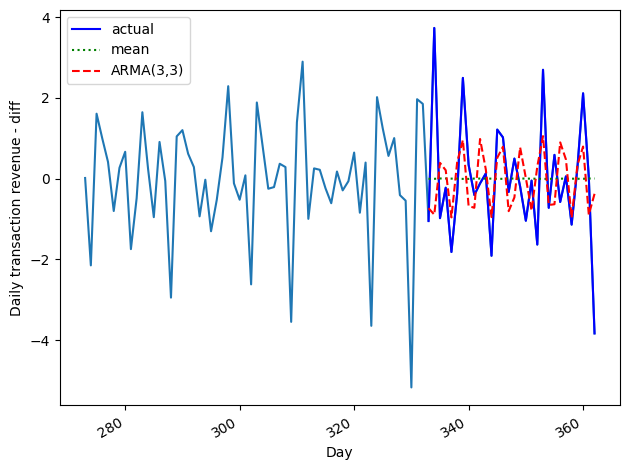

In [162]:
fig, ax = plt.subplots()

ax.plot(df_diff['log_rev_dff'].iloc[-90:])
ax.plot(test['log_rev_dff'].iloc[-90:], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
#ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'r--', label='ARMA(3,3)')

ax.legend(loc=2)

ax.set_xlabel('Day')
ax.set_ylabel('Daily transaction revenue - diff')


fig.autofmt_xdate()
plt.tight_layout()

plt.show()

In [163]:
mse_mean = mean_squared_error(test['log_rev_dff'], test['pred_mean'])
mse_last = mean_squared_error(test['log_rev_dff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['log_rev_dff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

2.1857941433600843 5.4737251489189935 1.9937612680912016


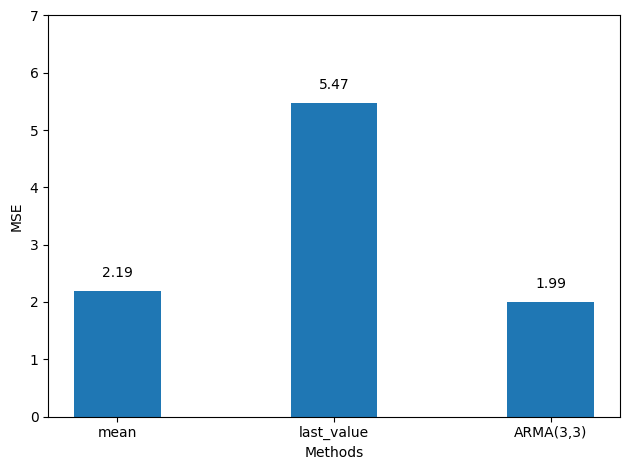

In [164]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(3,3)']
y = [mse_mean, mse_last, mse_ARMA] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.show()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)

### Daily revenue prediction

In [176]:
df_rev_ol['pred_revenue'] = pd.Series()
df_rev_ol['pred_revenue'][-30:] = df_rev_ol['log_rev'].iloc[-29] + test['pred_ARMA'].cumsum()

/var/folders/6p/hj30p4zj3n5dch8x1cy1bhyw0000gn/T/ipykernel_4400/1965515498.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6p/hj30p4zj3n5dch8x1cy1bhyw0000gn/T/ipykernel_4400/1965515498.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



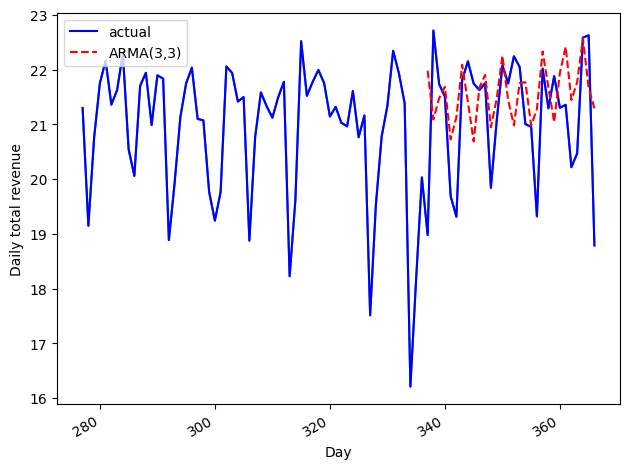

In [178]:
fig, ax = plt.subplots()

ax.plot(df_rev_ol['log_rev'].iloc[-90:])
ax.plot(df_rev_ol['log_rev'].iloc[-90:], 'b-', label='actual')
ax.plot(df_rev_ol['pred_revenue'], 'r--', label='ARMA(3,3)')

ax.legend(loc=2)

ax.set_xlabel('Day')
ax.set_ylabel('Daily total revenue')



fig.autofmt_xdate()
plt.tight_layout()

plt.show()